In [1]:
import slampy
import cv2
import numpy as np
from utils import *
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import rosbag
import numpy as np
from IPython.display import clear_output, display
from tqdm.notebook import tqdm
from scipy.spatial.transform import Rotation as R
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


ModuleNotFoundError: No module named 'scipy'

In [18]:
def upper_neighbor(df, value, colname):
    return df[df[colname] > value][colname].idxmin()

In [19]:
def calculate_combined_data(cam_outputs:list, threshold=0.3, conseq_frames=10, data_col_name='output'):
    cams = []
    indices = []
    tstamps = []
    first_res = [i.iloc[0][data_col_name] for i in cam_outputs]
    current_cam = first_res.index(max(first_res))
    current_index = -1
    current_res = 0
    prone_to_change = 0
    while True:
        cams.append(current_cam)
        indices.append(current_index)
        tstamps.append(cam_outputs[current_cam].iloc[current_index]['nsecs_str'])
        try:
            current_index += 1
            current_df = cam_outputs[current_cam].iloc[current_index]
        except IndexError:
            break
        if current_df[data_col_name] < threshold:
            if prone_to_change < conseq_frames:
                prone_to_change += 1
            else:
                next_indices = [upper_neighbor(i, current_df.nsecs, 'nsecs') for i in cam_outputs]
                next_dfs = [cam_outputs[i].iloc[next_indices[i]] for i in range(len(cam_outputs))]
                next_outputs = [i.output for i in next_dfs]
                next_best_cam = next_outputs.index(max(next_outputs))
                if not current_cam == next_best_cam:
                    current_cam = next_best_cam
                    current_index = next_indices[next_best_cam] - 1
                prone_to_change = 0
        else:
            prone_to_change = max([0, prone_to_change - 1])
    
    combined_data = pd.DataFrame()
    combined_data["cam"] = cams
    combined_data["tstamp"] = tstamps
    return combined_data

In [3]:
files = ["orb-classification/notebooks/outputs/regressor/2022-06-09/cam0.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-09/cam1.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-09/cam2.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-09/cam3.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-09/cam4.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-09/cam5.csv"]
c_09 = []
for f in files:
    c_09.append(pd.read_csv(f, header=0))
for current_c in c_09:
    current_c['nsecs_str'] = current_c.nsecs.astype(str)

In [4]:
files = ["orb-classification/notebooks/outputs/regressor/2022-06-10/cam0.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-10/cam1.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-10/cam2.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-10/cam3.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-10/cam4.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-10/cam5.csv"]
c_10 = []
for f in files:
    c_10.append(pd.read_csv(f, header=0))
for current_c in c_10:
    current_c['nsecs_str'] = current_c.nsecs.astype(str)

In [2]:
files = ["orb-classification/notebooks/outputs/classificator/2022-06-10/cam0.csv",
         "orb-classification/notebooks/outputs/classificator/2022-06-10/cam1.csv",
         "orb-classification/notebooks/outputs/classificator/2022-06-10/cam2.csv",
         "orb-classification/notebooks/outputs/classificator/2022-06-10/cam3.csv",
         "orb-classification/notebooks/outputs/classificator/2022-06-10/cam4.csv",
         "orb-classification/notebooks/outputs/classificator/2022-06-10/cam5.csv"]
cc_10 = []
for f in files:
    cc_10.append(pd.read_csv(f, header=0))
for current_c in cc_10:
    current_c['nsecs_str'] = current_c.nsecs.astype(str)

In [7]:
files = ["orb-classification/notebooks/outputs/classificator/2022-06-09/cam0.csv",
         "orb-classification/notebooks/outputs/classificator/2022-06-09/cam1.csv",
         "orb-classification/notebooks/outputs/classificator/2022-06-09/cam2.csv",
         "orb-classification/notebooks/outputs/classificator/2022-06-09/cam3.csv",
         "orb-classification/notebooks/outputs/classificator/2022-06-09/cam4.csv",
         "orb-classification/notebooks/outputs/classificator/2022-06-09/cam5.csv"]
cc_09 = []
for f in files:
    cc_09.append(pd.read_csv(f, header=0))
for current_c in cc_09:
    current_c['nsecs_str'] = current_c.nsecs.astype(str)

## Raw outputs

In [28]:
for cn in range(6):
    plt.plot(c_09[cn].nsecs[100,200], c_09[cn].output[100,200])
plt.show()

ValueError: key of type tuple not found and not a MultiIndex

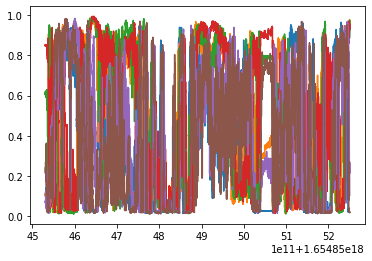

In [9]:
for cn in range(6):
    plt.plot(c_10[cn].nsecs, c_10[cn].output)
plt.show()

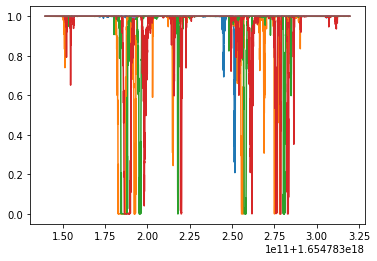

In [10]:
for cn in range(6):
    plt.plot(cc_09[cn].nsecs, cc_09[cn].output)
plt.show()

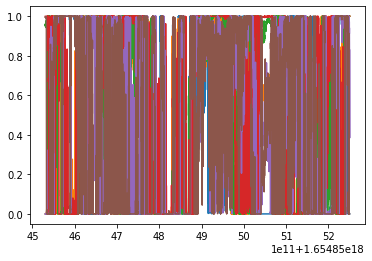

In [11]:
for cn in range(6):
    plt.plot(cc_10[cn].nsecs, cc_10[cn].output)
plt.show()

## EWM outputs

In [12]:
for cn in range(6):
    c_09[cn]["output_ewm"] = c_09[cn]["output"].ewm(alpha=0.1).mean()
    c_10[cn]["output_ewm"] = c_10[cn]["output"].ewm(alpha=0.1).mean()
    cc_09[cn]["output_ewm"] = cc_09[cn]["output"].ewm(alpha=0.1).mean()
    cc_10[cn]["output_ewm"] = cc_10[cn]["output"].ewm(alpha=0.1).mean()

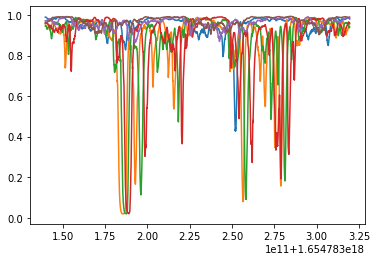

In [13]:
for cn in range(6):
    plt.plot(c_09[cn].nsecs, c_09[cn].output_ewm)
plt.show()

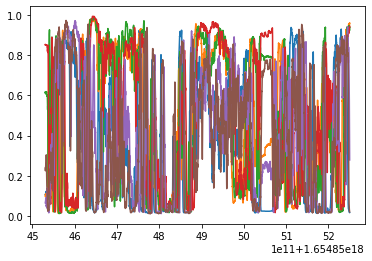

In [14]:
for cn in range(6):
    plt.plot(c_10[cn].nsecs, c_10[cn].output_ewm)
plt.show()

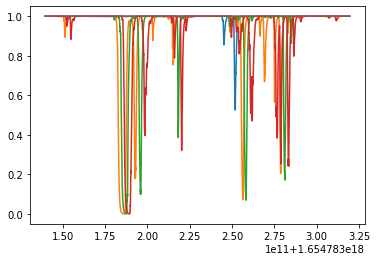

In [15]:
for cn in range(6):
    plt.plot(cc_09[cn].nsecs, cc_09[cn].output_ewm)
plt.show()

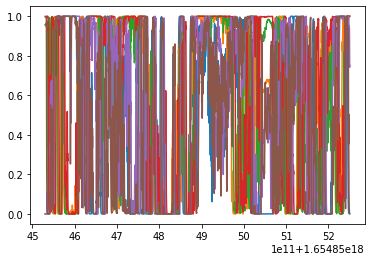

In [16]:
for cn in range(6):
    plt.plot(cc_10[cn].nsecs, cc_10[cn].output_ewm)
plt.show()

In [23]:
comb_09 = calculate_combined_data(c_09, threshold=0.95)
comb_09.cam = pd.to_numeric(comb_09.cam)
comb_09.tstamp = pd.to_numeric(comb_09.tstamp)

comb_10 = calculate_combined_data(c_10, threshold=0.3)
comb_10.cam = pd.to_numeric(comb_10.cam)
comb_10.tstamp = pd.to_numeric(comb_10.tstamp)

combc_09 = calculate_combined_data(cc_09, threshold=0.3)
combc_09.cam = pd.to_numeric(combc_09.cam)
combc_09.tstamp = pd.to_numeric(combc_09.tstamp)

combc_10 = calculate_combined_data(cc_10, threshold=0.3)
combc_10.cam = pd.to_numeric(combc_10.cam)
combc_10.tstamp = pd.to_numeric(combc_10.tstamp)

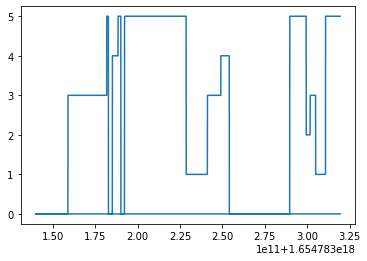

In [24]:
plt.plot(comb_09.tstamp, comb_09.cam)

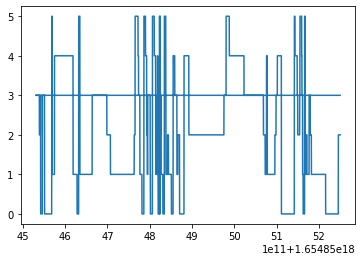

In [25]:
plt.plot(comb_10.tstamp, comb_10.cam)

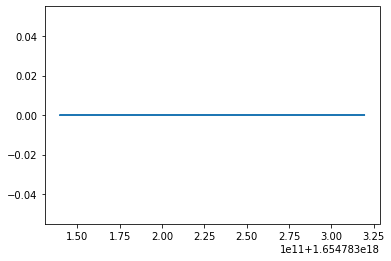

In [26]:
plt.plot(combc_09.tstamp, combc_09.cam)

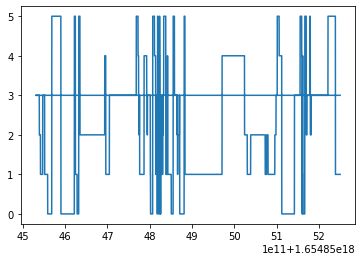

In [27]:
plt.plot(combc_10.tstamp, combc_10.cam)